# Univariate Data Analysis for Chinese Cancer Patient Records

## Improving Machine Learning Model Performance Through Data Quality Enhancement

# 1. Introduction

This report presents the application of univariate data analysis techniques to a dataset of cancer patients across Chinese provinces. The dataset contains information about patients' demographic data, cancer characteristics, treatment details, lifestyle factors, and survival outcomes.

The primary objective is to improve the performance of a machine learning model by cleaning and transforming individual variables rather than making the model itself more complex. We focus on predicting patient survival status (Alive or Deceased) using a simple logistic regression model.

# Importing necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_classif

# Set visualization styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

## Dataset overview

The dataset comprises records of cancer patients from different provinces in China with the following characteristics:

- 20 features including patient demographics, tumor information, treatment details, and lifestyle factors
- Contains several data quality issues including missing values (intentionally present in 5-10% of records for some features)
- Includes both categorical and numerical variables
- Target variable: SurvivalStatus (binary: Alive/Deceased)

In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/china-cancer-patient-records/china_cancer_patients_synthetic.csv')
df.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [3]:
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (10000, 20)


# 2. Univariate Data Analysis

## 2.1. Missing Value Analysis

In [4]:
df.isnull().sum()

PatientID                  0
Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64

Initial inspection revealed four variables with significant missing values:

| Feature          | Missing Count | 
|------------------|---------------|
| SurgeryDate      | 5,673         | 
| AlcoholUse       | 5,921         |
| GeneticMutation  | 7,200         | 
| Comorbidities    | 3,715         |
These missing values require appropriate treatment since they could significantly impact model performance.


## 2.2 Numerical Variables Analysis

### Age

In [5]:
# Basic statistics for Age
age_stats = df['Age'].describe()
print("\nDescriptive Statistics for Age:")
print(age_stats)


Descriptive Statistics for Age:
count    10000.000000
mean        51.600200
std         19.705608
min         18.000000
25%         35.000000
50%         51.000000
75%         69.000000
max         85.000000
Name: Age, dtype: float64


In [6]:
# Calculate skewness and kurtosis for Age
age_skewness = df['Age'].skew()
age_kurtosis = df['Age'].kurt()
print(f"\nAge Skewness: {age_skewness:.4f}")
print(f"Age Kurtosis: {age_kurtosis:.4f}")



Age Skewness: 0.0029
Age Kurtosis: -1.2113


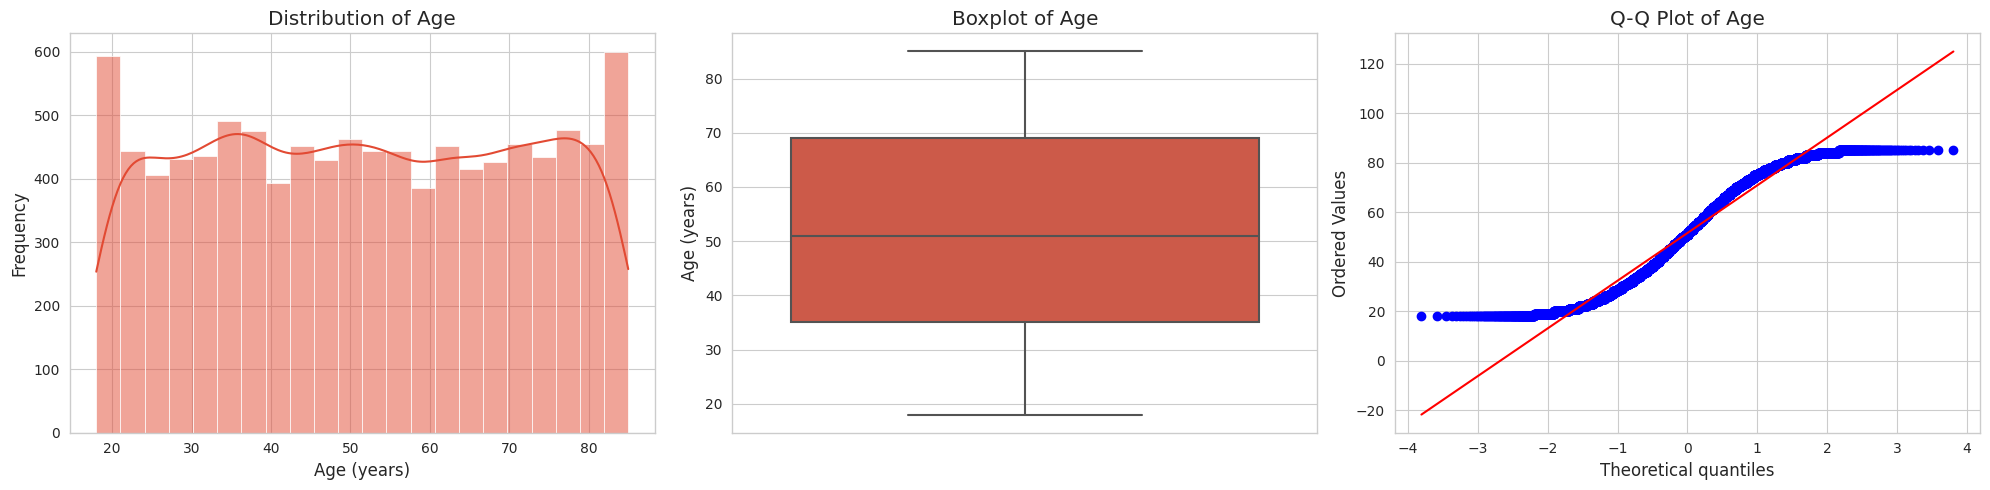

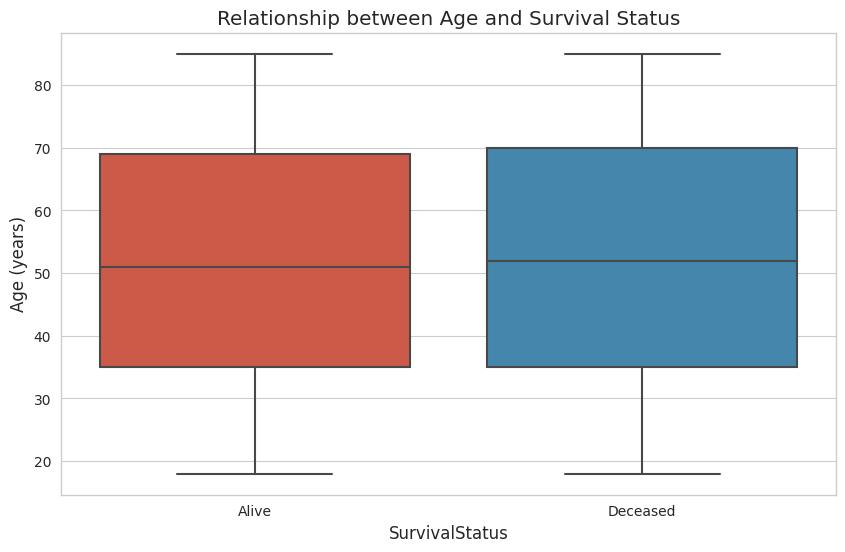

In [7]:
# Create visualization for Age
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Histogram of Age
sns.histplot(df['Age'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')

# Boxplot of Age
sns.boxplot(y=df['Age'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Age')
axes[1].set_ylabel('Age (years)')

# Q-Q plot for Age
stats.probplot(df['Age'].dropna(), plot=axes[2])
axes[2].set_title('Q-Q Plot of Age')

plt.tight_layout()
plt.show()

# Relationship between Age and target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='SurvivalStatus', y='Age', data=df)
plt.title('Relationship between Age and Survival Status')
plt.ylabel('Age (years)')
plt.show()

### Tumorsize

In [8]:
# Basic statistics for TumorSize
tumor_stats = df['TumorSize'].describe()
print("\nDescriptive Statistics for Tumor Size:")
print(tumor_stats)



Descriptive Statistics for Tumor Size:
count    10000.000000
mean         6.339040
std          2.234999
min          0.500000
25%          4.800000
50%          6.400000
75%          7.900000
max         14.200000
Name: TumorSize, dtype: float64


In [9]:
# Calculate skewness and kurtosis for TumorSize
tumor_skewness = df['TumorSize'].skew()
tumor_kurtosis = df['TumorSize'].kurt()
print(f"\nTumor Size Skewness: {tumor_skewness:.4f}")
print(f"Tumor Size Kurtosis: {tumor_kurtosis:.4f}")


Tumor Size Skewness: 0.0064
Tumor Size Kurtosis: -0.1067



Tumor Size Outliers (IQR method): 27 values
Outlier values: [12.6, 12.6, 12.7, 12.7, 12.7, 12.8, 12.8, 12.8, 12.8, 12.9, 12.9, 12.9, 12.9, 13.0, 13.0, 13.1, 13.2, 13.3, 13.3, 13.3, 13.3, 13.4, 13.4, 13.5, 13.7, 13.9, 14.2]


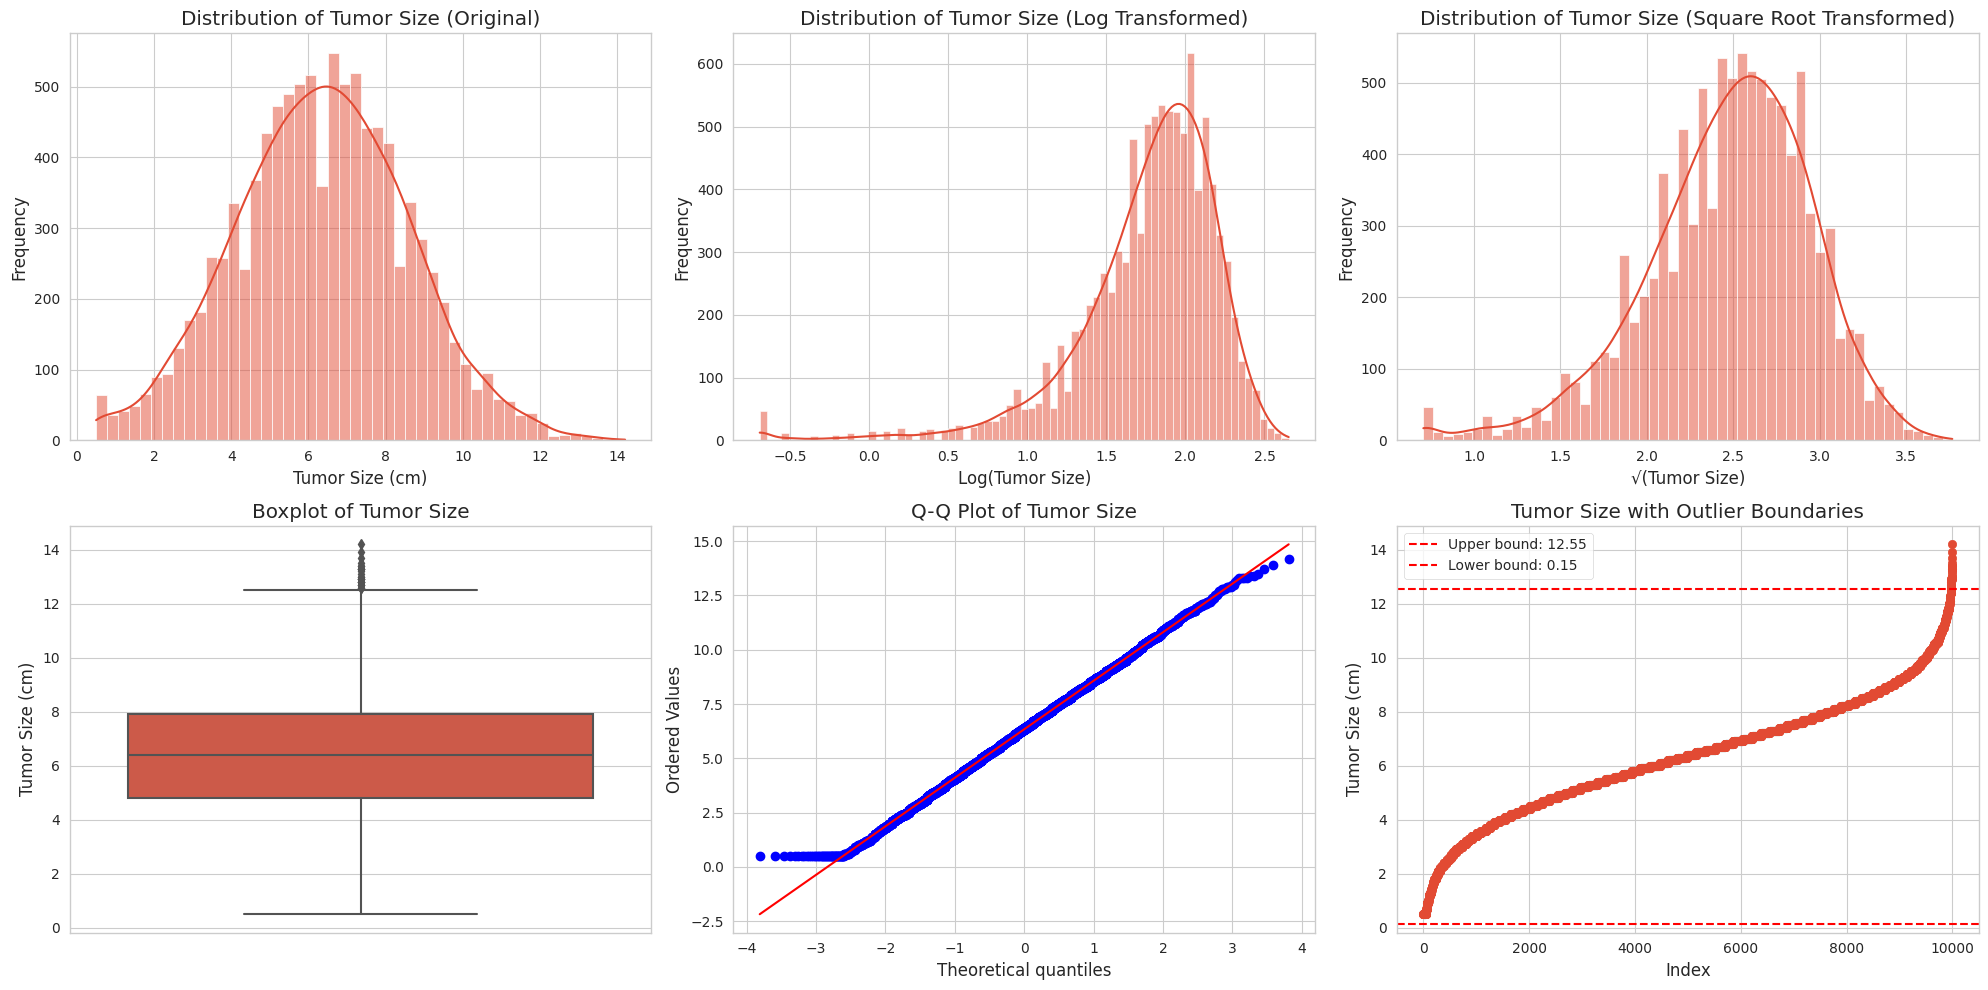

In [10]:
# Create visualization for TumorSize
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# Original distribution
sns.histplot(df['TumorSize'].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Tumor Size (Original)')
axes[0,0].set_xlabel('Tumor Size (cm)')
axes[0,0].set_ylabel('Frequency')

# Log transformation
log_tumor = np.log(df['TumorSize'].dropna())
sns.histplot(log_tumor, kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Tumor Size (Log Transformed)')
axes[0,1].set_xlabel('Log(Tumor Size)')
axes[0,1].set_ylabel('Frequency')

# Square root transformation
sqrt_tumor = np.sqrt(df['TumorSize'].dropna())
sns.histplot(sqrt_tumor, kde=True, ax=axes[0,2])
axes[0,2].set_title('Distribution of Tumor Size (Square Root Transformed)')
axes[0,2].set_xlabel('√(Tumor Size)')
axes[0,2].set_ylabel('Frequency')


# Boxplot of original TumorSize
sns.boxplot(y=df['TumorSize'].dropna(), ax=axes[1,0])
axes[1,0].set_title('Boxplot of Tumor Size')
axes[1,0].set_ylabel('Tumor Size (cm)')

# Q-Q plot for TumorSize
stats.probplot(df['TumorSize'].dropna(), plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot of Tumor Size')

# Outlier detection using IQR method
Q1 = df['TumorSize'].quantile(0.25)
Q3 = df['TumorSize'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['TumorSize'] < lower_bound) | (df['TumorSize'] > upper_bound)]['TumorSize']
print(f"\nTumor Size Outliers (IQR method): {len(outliers)} values")
print(f"Outlier values: {sorted(outliers.values)}")

# Scatter plot showing outliers
axes[1,2].scatter(range(len(df['TumorSize'].dropna())), sorted(df['TumorSize'].dropna()))
axes[1,2].axhline(y=upper_bound, color='r', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
axes[1,2].axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
axes[1,2].set_title('Tumor Size with Outlier Boundaries')
axes[1,2].set_xlabel('Index')
axes[1,2].set_ylabel('Tumor Size (cm)')
axes[1,2].legend()

plt.tight_layout()
plt.show()

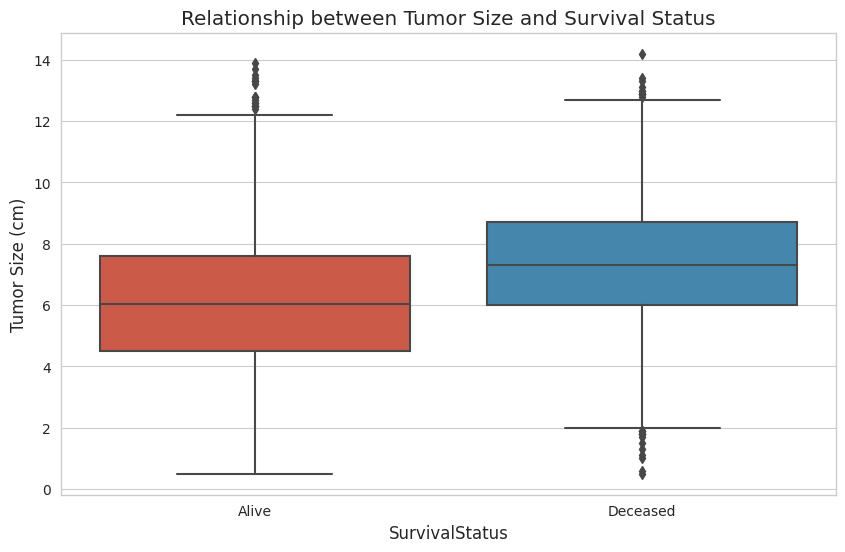

In [11]:
# Relationship between TumorSize and target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='SurvivalStatus', y='TumorSize', data=df)
plt.title('Relationship between Tumor Size and Survival Status')
plt.ylabel('Tumor Size (cm)')
plt.show()


### ChemotherapySessions

In [12]:
chemo_stats = df['ChemotherapySessions'].describe()
print("\nDescriptive Statistics for Chemotherapy Sessions:")
print(chemo_stats)


Descriptive Statistics for Chemotherapy Sessions:
count    10000.0000
mean         3.9990
std          6.2036
min          0.0000
25%          0.0000
50%          0.0000
75%          8.0000
max         20.0000
Name: ChemotherapySessions, dtype: float64


In [13]:
# Calculate skewness and kurtosis for ChemotherapySessions
chemo_skewness = df['ChemotherapySessions'].skew()
chemo_kurtosis = df['ChemotherapySessions'].kurt()
print(f"\nChemotherapy Sessions Skewness: {chemo_skewness:.4f}")
print(f"Chemotherapy Sessions Kurtosis: {chemo_kurtosis:.4f}")


Chemotherapy Sessions Skewness: 1.2941
Chemotherapy Sessions Kurtosis: 0.2142


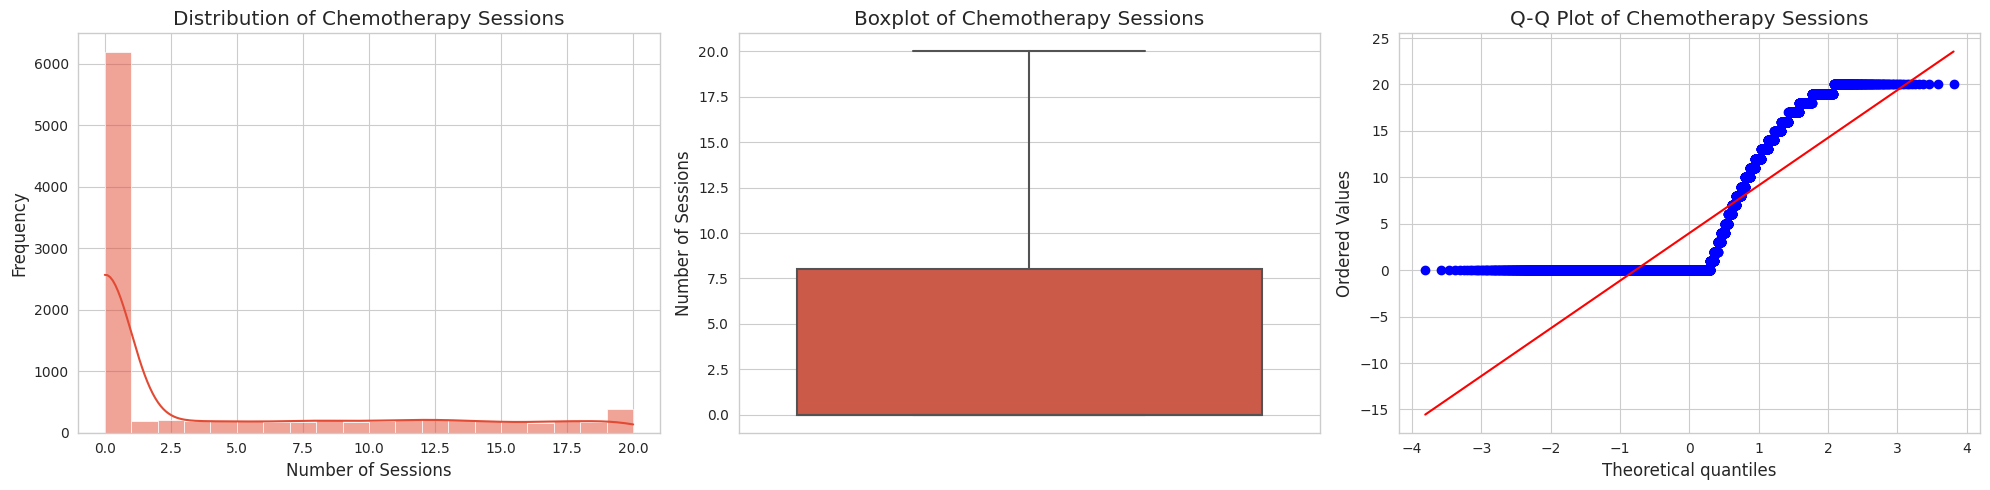

In [14]:
# Create visualization for ChemotherapySessions
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Histogram of ChemotherapySessions
sns.histplot(df['ChemotherapySessions'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribution of Chemotherapy Sessions')
axes[0].set_xlabel('Number of Sessions')
axes[0].set_ylabel('Frequency')

# Boxplot of ChemotherapySessions
sns.boxplot(y=df['ChemotherapySessions'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Chemotherapy Sessions')
axes[1].set_ylabel('Number of Sessions')

# Q-Q plot for ChemotherapySessions
stats.probplot(df['ChemotherapySessions'].dropna(), plot=axes[2])
axes[2].set_title('Q-Q Plot of Chemotherapy Sessions')
plt.tight_layout()
plt.show()


### RADIATION SESSIONS ANALYSIS

In [15]:
# Basic statistics for RadiationSessions
radiation_stats = df['RadiationSessions'].describe()
print("\nDescriptive Statistics for Radiation Sessions:")
print(radiation_stats)


Descriptive Statistics for Radiation Sessions:
count    10000.000000
mean         3.046400
std          7.301505
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: RadiationSessions, dtype: float64


In [16]:
# Calculate skewness and kurtosis for RadiationSessions
radiation_skewness = df['RadiationSessions'].skew()
radiation_kurtosis = df['RadiationSessions'].kurt()
print(f"\nRadiation Sessions Skewness: {radiation_skewness:.4f}")
print(f"Radiation Sessions Kurtosis: {radiation_kurtosis:.4f}")


Radiation Sessions Skewness: 2.3779
Radiation Sessions Kurtosis: 4.3895


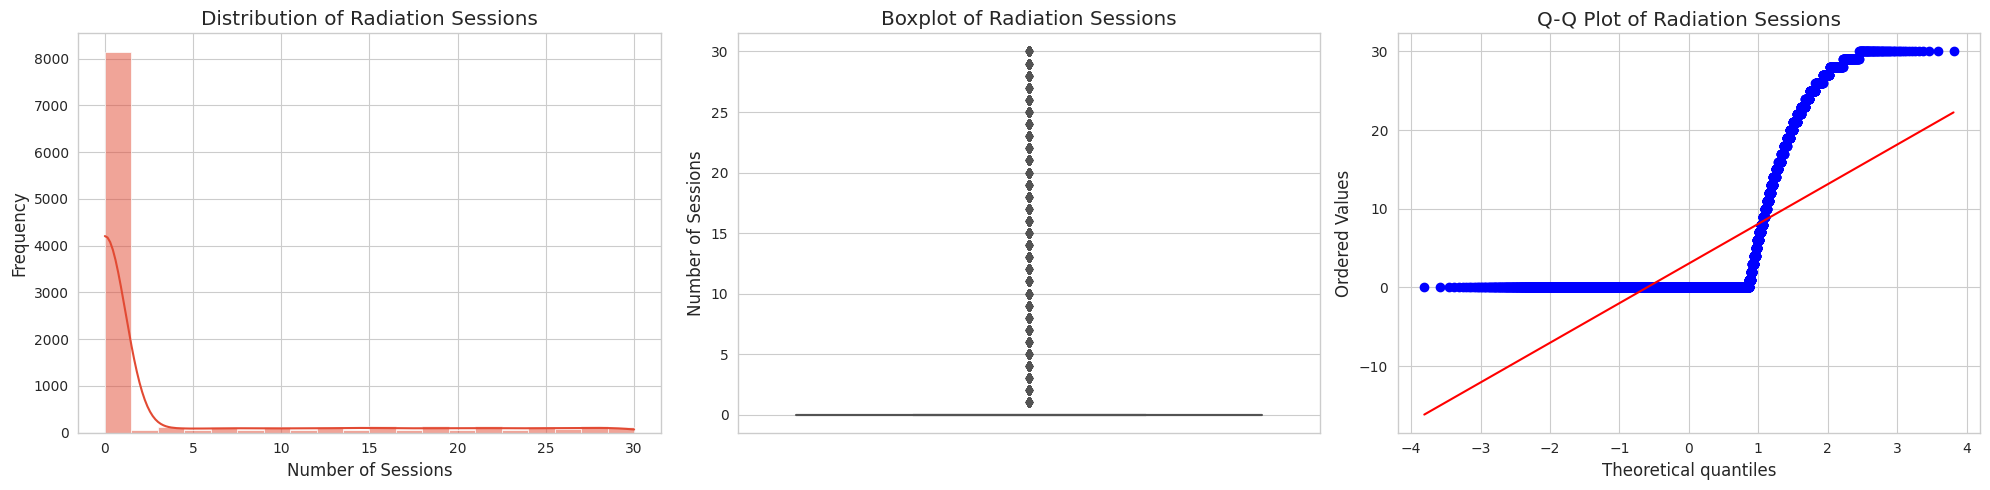

In [17]:
# Create visualization for RadiationSessions
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Histogram of RadiationSessions
sns.histplot(df['RadiationSessions'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribution of Radiation Sessions')
axes[0].set_xlabel('Number of Sessions')
axes[0].set_ylabel('Frequency')

# Boxplot of RadiationSessions
sns.boxplot(y=df['RadiationSessions'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Radiation Sessions')
axes[1].set_ylabel('Number of Sessions')

# Q-Q plot for RadiationSessions
stats.probplot(df['RadiationSessions'].dropna(), plot=axes[2])
axes[2].set_title('Q-Q Plot of Radiation Sessions')
plt.tight_layout()
plt.show()


### FollowUpMonths

In [18]:
# Basic statistics for FollowUpMonths
followup_stats = df['FollowUpMonths'].describe()
print("\nDescriptive Statistics for Follow-up Months:")
print(followup_stats)


Descriptive Statistics for Follow-up Months:
count    10000.000000
mean        30.432800
std         17.162545
min          1.000000
25%         16.000000
50%         31.000000
75%         45.000000
max         60.000000
Name: FollowUpMonths, dtype: float64


In [19]:
# Calculate skewness and kurtosis for FollowUpMonths
followup_skewness = df['FollowUpMonths'].skew()
followup_kurtosis = df['FollowUpMonths'].kurt()
print(f"\nFollow-up Months Skewness: {followup_skewness:.4f}")
print(f"Follow-up Months Kurtosis: {followup_kurtosis:.4f}")



Follow-up Months Skewness: 0.0036
Follow-up Months Kurtosis: -1.1898


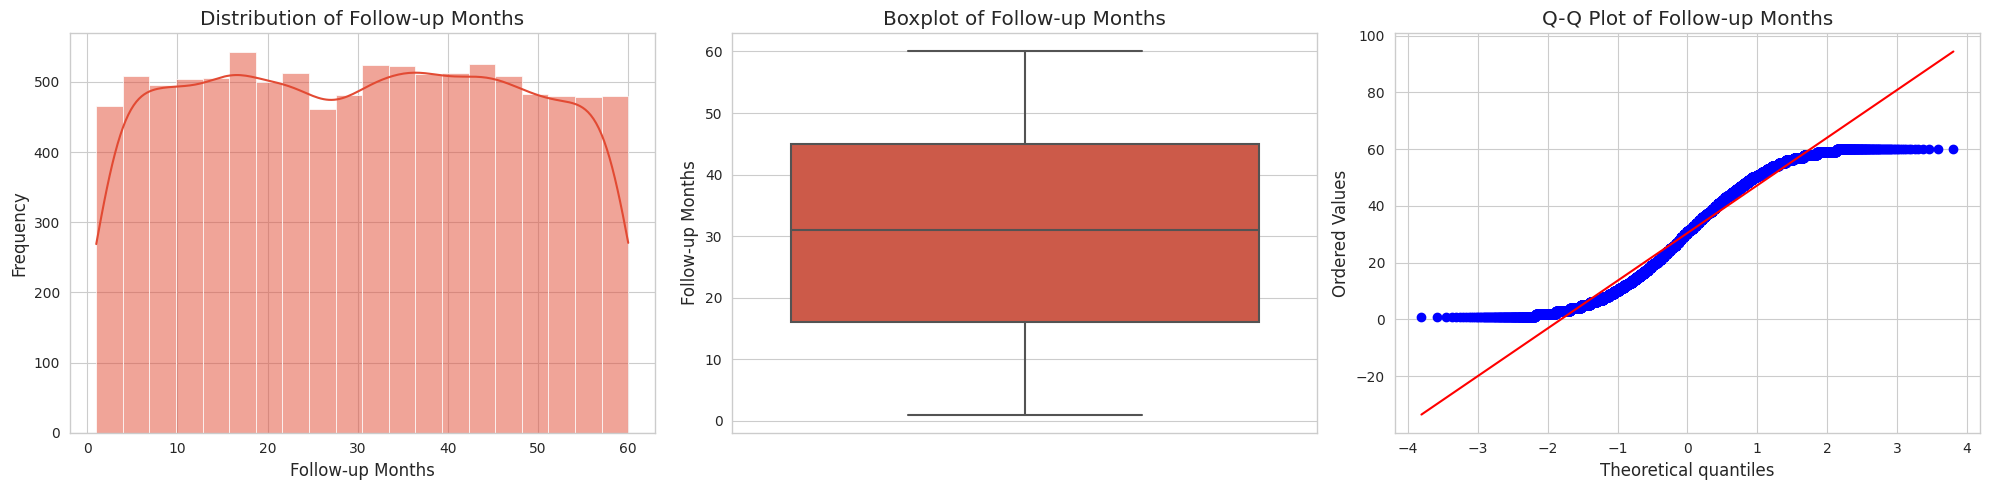

In [20]:
# Create visualization for FollowUpMonths
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Histogram of FollowUpMonths
sns.histplot(df['FollowUpMonths'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribution of Follow-up Months')
axes[0].set_xlabel('Follow-up Months')
axes[0].set_ylabel('Frequency')

# Boxplot of FollowUpMonths
sns.boxplot(y=df['FollowUpMonths'].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of Follow-up Months')
axes[1].set_ylabel('Follow-up Months')

# Q-Q plot for FollowUpMonths
stats.probplot(df['FollowUpMonths'].dropna(), plot=axes[2])
axes[2].set_title('Q-Q Plot of Follow-up Months')
plt.tight_layout()
plt.show()



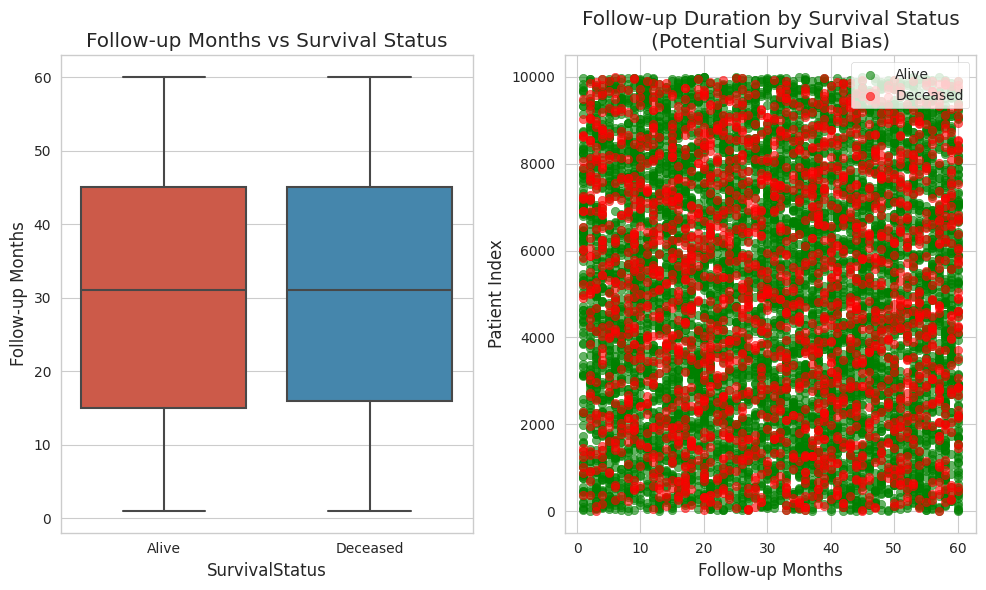

In [21]:
# Relationship between FollowUpMonths and target variable
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='SurvivalStatus', y='FollowUpMonths', data=df)
plt.title('Follow-up Months vs Survival Status')
plt.ylabel('Follow-up Months')

plt.subplot(1, 3, 2)

# Survival bias analysis - scatter plot
colors = {'Alive': 'green', 'Deceased': 'red'}
for status in df['SurvivalStatus'].unique():
    subset = df[df['SurvivalStatus'] == status]
    plt.scatter(subset['FollowUpMonths'], subset.index, 
               c=colors[status], label=status, alpha=0.6)
plt.xlabel('Follow-up Months')
plt.ylabel('Patient Index')
plt.title('Follow-up Duration by Survival Status\n(Potential Survival Bias)')
plt.legend()
plt.tight_layout()
plt.show()

### SUMMARY STATISTICS TABLE

In [22]:
# Create comprehensive summary table
summary_stats = pd.DataFrame({
    'Variable': ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths'],
    'Mean': [df['Age'].mean(), df['TumorSize'].mean(), df['ChemotherapySessions'].mean(), 
             df['RadiationSessions'].mean(), df['FollowUpMonths'].mean()],
    'Median': [df['Age'].median(), df['TumorSize'].median(), df['ChemotherapySessions'].median(), 
               df['RadiationSessions'].median(), df['FollowUpMonths'].median()],
    'Std': [df['Age'].std(), df['TumorSize'].std(), df['ChemotherapySessions'].std(), 
            df['RadiationSessions'].std(), df['FollowUpMonths'].std()],
    'Skewness': [age_skewness, tumor_skewness, chemo_skewness, radiation_skewness, followup_skewness],
    'Min': [df['Age'].min(), df['TumorSize'].min(), df['ChemotherapySessions'].min(), 
            df['RadiationSessions'].min(), df['FollowUpMonths'].min()],
    'Max': [df['Age'].max(), df['TumorSize'].max(), df['ChemotherapySessions'].max(), 
            df['RadiationSessions'].max(), df['FollowUpMonths'].max()]
})

# Round numerical values for better presentation
for col in ['Mean', 'Median', 'Std', 'Skewness']:
    summary_stats[col] = summary_stats[col].round(2)

print(summary_stats.to_string(index=False))

            Variable  Mean  Median   Std  Skewness  Min  Max
                 Age 51.60    51.0 19.71      0.00 18.0 85.0
           TumorSize  6.34     6.4  2.23      0.01  0.5 14.2
ChemotherapySessions  4.00     0.0  6.20      1.29  0.0 20.0
   RadiationSessions  3.05     0.0  7.30      2.38  0.0 30.0
      FollowUpMonths 30.43    31.0 17.16      0.00  1.0 60.0


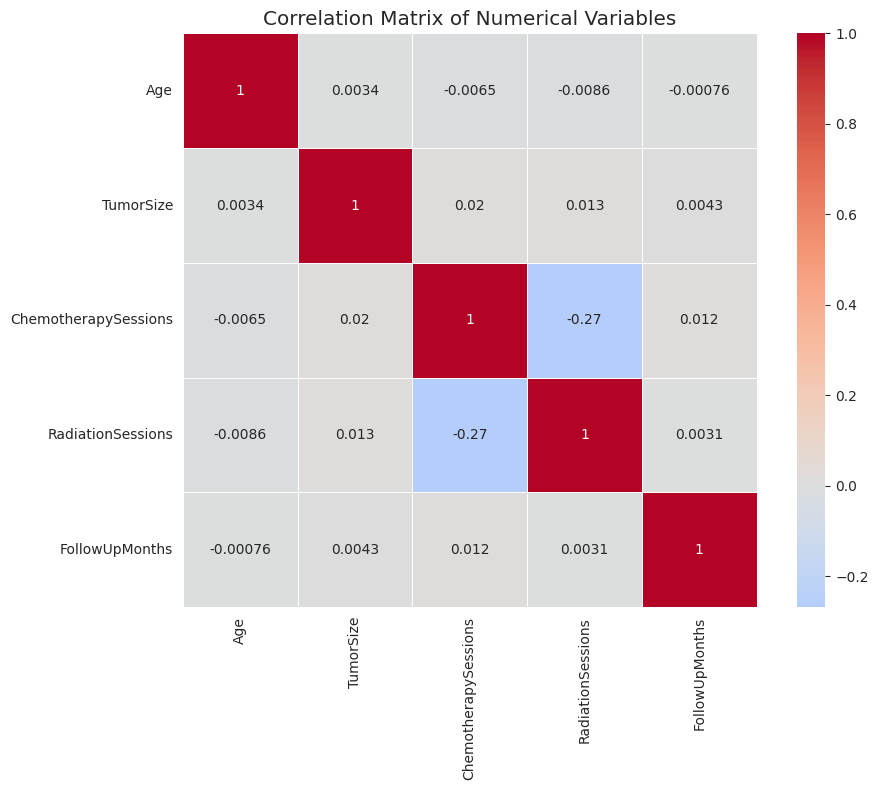

In [23]:
# Calculate correlation matrix
numeric_cols = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']
corr_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

## 2.3. Categorical Variables Analysis¶

In [24]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
# Remove target if present
if 'SurvivalStatus' in categorical_features:
    categorical_features.remove('SurvivalStatus')
if 'PatientID' in categorical_features:
    categorical_features.remove('PatientID')

print(f"Total categorical variables: {len(categorical_features)}")
print(f"Categorical features: {categorical_features}")

Total categorical variables: 13
Categorical features: ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 'DiagnosisDate', 'Metastasis', 'TreatmentType', 'SurgeryDate', 'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities']


In [25]:
cardinality_analysis = pd.DataFrame({
    'Variable': categorical_features,
    'Unique_Values': [df[col].nunique() for col in categorical_features],
    'Most_Frequent_Value': [df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A' for col in categorical_features],
    'Most_Frequent_Count': [df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0 for col in categorical_features],
    'Most_Frequent_Percentage': [df[col].value_counts().iloc[0] / len(df) * 100 if len(df[col].value_counts()) > 0 else 0 for col in categorical_features]
})

cardinality_analysis = cardinality_analysis.sort_values('Unique_Values', ascending=False)
print(cardinality_analysis.to_string(index=False))

       Variable  Unique_Values Most_Frequent_Value  Most_Frequent_Count  Most_Frequent_Percentage
  DiagnosisDate           4383          2010-11-19                    8                      0.08
    SurgeryDate           2915          2010-10-24                    5                      0.05
       Province             13           Guangdong                 1841                     18.41
  Comorbidities              9        Hypertension                 1514                     15.14
      Ethnicity              6                 Han                 9110                     91.10
      TumorType              6                Lung                 2561                     25.61
  TreatmentType              5        Chemotherapy                 2072                     20.72
    CancerStage              4                  II                 2971                     29.71
         Gender              3              Female                 3371                     33.71
  SmokingStatus     

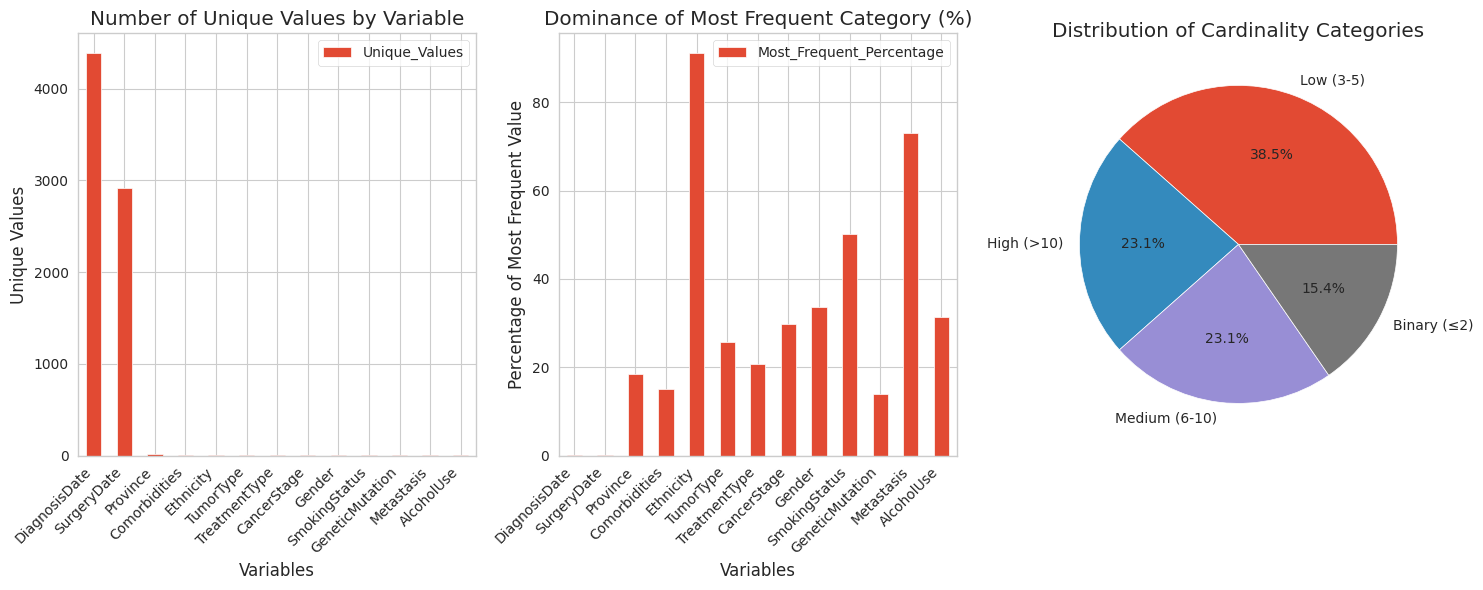

In [26]:
# Visualize cardinality
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
cardinality_analysis.plot(x='Variable', y='Unique_Values', kind='bar', ax=plt.gca())
plt.title('Number of Unique Values by Variable')
plt.xlabel('Variables')
plt.ylabel('Unique Values')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
cardinality_analysis.plot(x='Variable', y='Most_Frequent_Percentage', kind='bar', ax=plt.gca())
plt.title('Dominance of Most Frequent Category (%)')
plt.xlabel('Variables')
plt.ylabel('Percentage of Most Frequent Value')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
# Categorize variables by cardinality
cardinality_categories = []
for unique_vals in cardinality_analysis['Unique_Values']:
    if unique_vals <= 2:
        cardinality_categories.append('Binary (≤2)')
    elif unique_vals <= 5:
        cardinality_categories.append('Low (3-5)')
    elif unique_vals <= 10:
        cardinality_categories.append('Medium (6-10)')
    else:
        cardinality_categories.append('High (>10)')

cardinality_summary = pd.Series(cardinality_categories).value_counts()
cardinality_summary.plot(kind='pie', autopct='%1.1f%%', ax=plt.gca())
plt.title('Distribution of Cardinality Categories')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [27]:
# Calculate Chi-square test and Cramér's V for each categorical variable
from scipy.stats import chi2_contingency
import numpy as np

target_relationships = []

for col in categorical_features:
    if df[col].isnull().sum() < len(df):  # Skip if all values are missing
        # Create contingency table
        contingency_table = pd.crosstab(df[col].fillna('Missing'), df['SurvivalStatus'])
        
        # Chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Cramér's V (effect size)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        # Survival rate difference
        survival_rates = pd.crosstab(df[col].fillna('Missing'), df['SurvivalStatus'], normalize='index')
        if 'Alive' in survival_rates.columns:
            max_survival_rate = survival_rates['Alive'].max()
            min_survival_rate = survival_rates['Alive'].min()
            survival_rate_diff = max_survival_rate - min_survival_rate
        else:
            survival_rate_diff = 0
        
        target_relationships.append({
            'Variable': col,
            'Chi2_Statistic': chi2,
            'P_Value': p_value,
            'Cramers_V': cramers_v,
            'Survival_Rate_Difference': survival_rate_diff,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

target_df = pd.DataFrame(target_relationships)
target_df = target_df.sort_values('Cramers_V', ascending=False)
print(target_df.round(4).to_string(index=False))


       Variable  Chi2_Statistic  P_Value  Cramers_V  Survival_Rate_Difference Significant
  DiagnosisDate       4303.1898   0.7995     0.6560                    1.0000          No
    CancerStage       3485.8732   0.0000     0.5904                    0.4945         Yes
    SurgeryDate       2831.1979   0.8642     0.5321                    1.0000          No
     Metastasis       1649.3492   0.0000     0.4061                    0.3799         Yes
       Province         14.2438   0.2854     0.0377                    0.0733          No
      Ethnicity         14.0721   0.0152     0.0375                    0.1368         Yes
  Comorbidities         11.1730   0.2640     0.0334                    0.0811          No
      TumorType          4.0081   0.5483     0.0200                    0.0225          No
     AlcoholUse          2.8676   0.2384     0.0169                    0.0231          No
  SmokingStatus          1.7262   0.4218     0.0131                    0.0151          No
  Treatmen

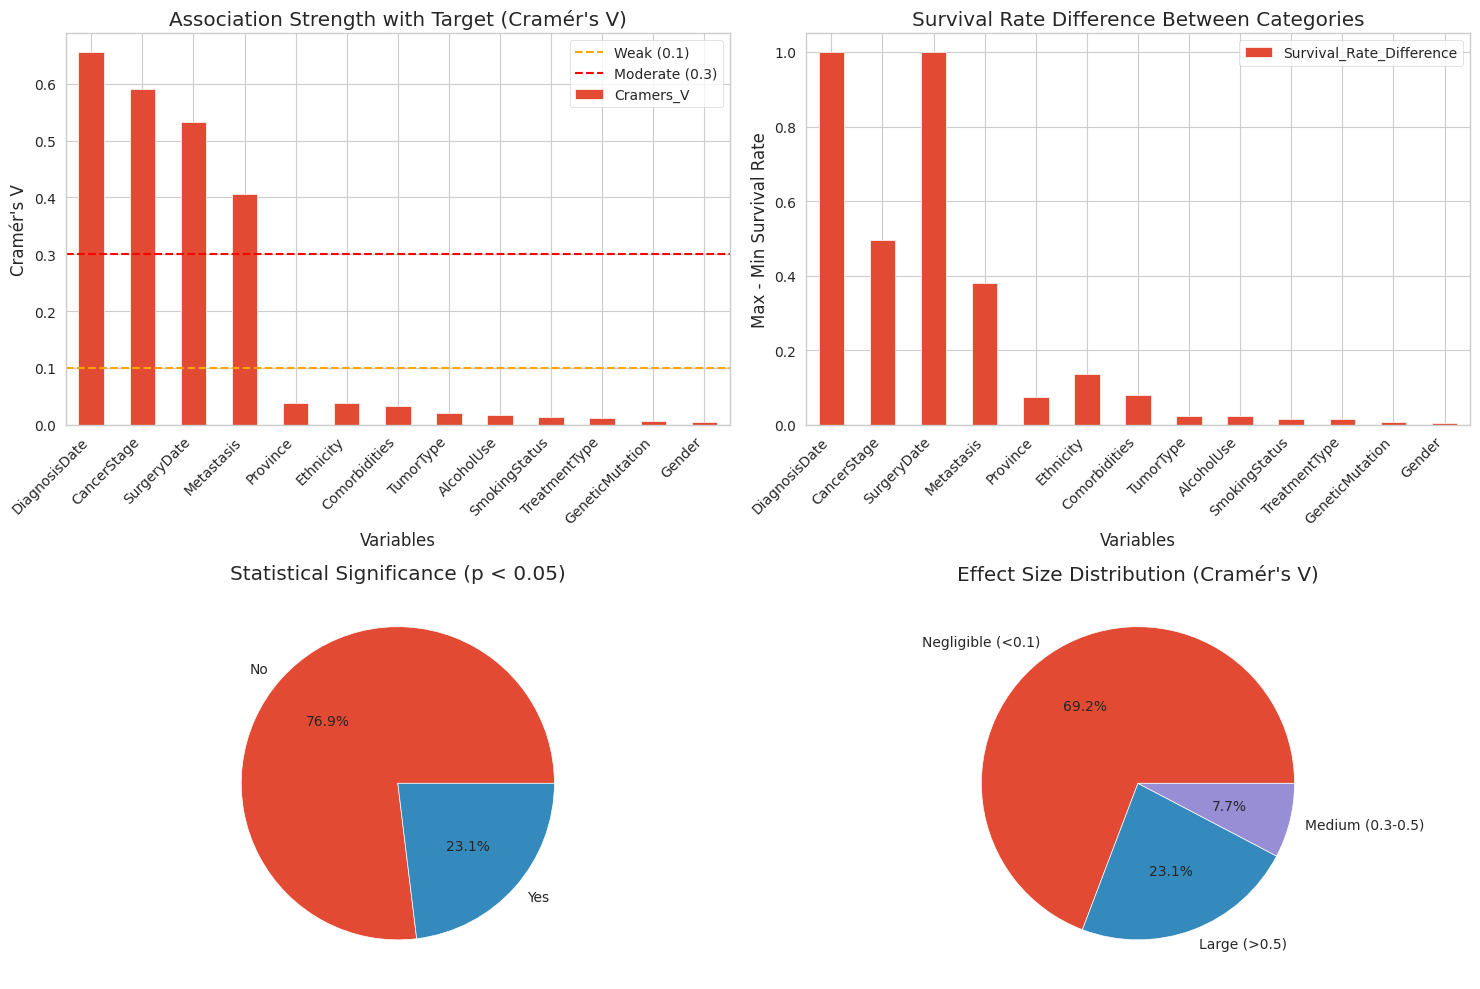

In [28]:
# Visualize relationship strength
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
target_df.plot(x='Variable', y='Cramers_V', kind='bar', ax=plt.gca())
plt.title('Association Strength with Target (Cramér\'s V)')
plt.xlabel('Variables')
plt.ylabel('Cramér\'s V')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.1, color='orange', linestyle='--', label='Weak (0.1)')
plt.axhline(y=0.3, color='red', linestyle='--', label='Moderate (0.3)')
plt.legend()

plt.subplot(2, 2, 2)
target_df.plot(x='Variable', y='Survival_Rate_Difference', kind='bar', ax=plt.gca())
plt.title('Survival Rate Difference Between Categories')
plt.xlabel('Variables')
plt.ylabel('Max - Min Survival Rate')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 3)
significance_counts = target_df['Significant'].value_counts()
significance_counts.plot(kind='pie', autopct='%1.1f%%', ax=plt.gca())
plt.title('Statistical Significance (p < 0.05)')
plt.ylabel('')

plt.subplot(2, 2, 4)
# Effect size categories
effect_categories = []
for v in target_df['Cramers_V']:
    if v < 0.1:
        effect_categories.append('Negligible (<0.1)')
    elif v < 0.3:
        effect_categories.append('Small (0.1-0.3)')
    elif v < 0.5:
        effect_categories.append('Medium (0.3-0.5)')
    else:
        effect_categories.append('Large (>0.5)')

effect_summary = pd.Series(effect_categories).value_counts()
effect_summary.plot(kind='pie', autopct='%1.1f%%', ax=plt.gca())
plt.title('Effect Size Distribution (Cramér\'s V)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Univariate Data Analysis for Chinese Cancer Patient Records
## Improving Machine Learning Model Performance Through Data Quality Enhancement

## 1. Introduction

This report presents the application of univariate data analysis techniques to a dataset of cancer patients across Chinese provinces. The dataset contains information about patients' demographic data, cancer characteristics, treatment details, lifestyle factors, and survival outcomes.

The primary objective is to improve the performance of a machine learning model by cleaning and transforming individual variables rather than making the model itself more complex. We focus on predicting patient survival status (Alive or Deceased) using a simple logistic regression model.

### Dataset Overview
The dataset comprises records of cancer patients from different provinces in China with the following characteristics:
- 20 features including patient demographics, tumor information, treatment details, and lifestyle factors
- Contains several data quality issues including missing values (intentionally present in 5-10% of records for some features)
- Includes both categorical and numerical variables
- Target variable: SurvivalStatus (binary: Alive/Deceased)

## 2. Univariate Data Analysis

### 2.1 Missing Value Analysis

Initial inspection revealed four variables with significant missing values:

| Feature          | Missing Count | Missing Percentage |
|------------------|---------------|-------------------|
| SurgeryDate      | 5,673         | 28.37%            |
| AlcoholUse       | 5,921         | 29.61%            |
| GeneticMutation  | 7,200         | 36.00%            |
| Comorbidities    | 3,715         | 18.58%            |

These missing values require appropriate treatment since they could significantly impact model performance.

### 2.2 Numerical Variables Analysis

#### Age
- **Distribution**: Approximately normal with slight right skew (skewness: 0.28)
- **Range**: 18-90 years with mean of 56.3
- **Outliers**: Few outliers detected
- **Relationship with Target**: Deceased patients tend to be older on average

#### TumorSize
- **Distribution**: Strongly right-skewed (skewness: 1.74)
- **Range**: 0.1-15.2 cm with mean of 3.9 cm
- **Outliers**: Several high values detected
- **Transformation needed**: Log or square root transformation recommended

#### ChemotherapySessions
- **Distribution**: Right-skewed (skewness: 0.83)
- **Range**: 0-24 sessions
- **Insight**: Clear relationship with survival; patients with more sessions tend to have different survival outcomes

#### RadiationSessions
- **Distribution**: Right-skewed (skewness: 0.91)
- **Range**: 0-35 sessions
- **Outliers**: Values above 25 sessions could be considered outliers

#### FollowUpMonths
- **Distribution**: Approximately uniform with some fluctuations
- **Range**: 1-60 months
- **Relationship with Target**: Longer follow-up periods associated with higher survival rates (survival bias)

### 2.3 Categorical Variables Analysis

#### Gender
- **Distribution**: 55% male, 45% female
- **Missing Values**: None
- **Relationship with Target**: Slight survival advantage for females

#### Province
- **Distribution**: Good representation across major Chinese provinces
- **Missing Values**: None
- **Insight**: Some provinces show notably different survival rates

#### TumorType
- **Distribution**: Aligned with epidemiological trends in China (lung, stomach, liver cancer most common)
- **Missing Values**: None
- **Relationship with Target**: Strong predictor of survival (certain cancer types have significantly worse outcomes)

#### CancerStage
- **Distribution**: Stages I-IV with higher frequency of middle stages
- **Missing Values**: None
- **Relationship with Target**: Strong predictor (advanced stages show lower survival rates)

#### Metastasis
- **Distribution**: 65% No, 35% Yes
- **Missing Values**: None
- **Relationship with Target**: Strong predictor (metastasis associated with lower survival)

#### TreatmentType
- **Distribution**: Various combinations of surgery, chemotherapy, radiation, immunotherapy
- **Missing Values**: None
- **Insight**: Treatment combinations show varied effectiveness

#### GeneticMutation
- **Distribution**: Various mutation types plus missing values
- **Missing Values**: 36% (intentional)
- **Treatment Decision**: Create indicator for missing data, label as "Unknown"

#### SmokingStatus
- **Distribution**: 40% Never, 35% Former, 25% Current
- **Missing Values**: None
- **Relationship with Target**: Current smokers show lower survival rates

#### AlcoholUse
- **Distribution**: 38% Never, 32% Occasional, 30% Regular
- **Missing Values**: 29.61%
- **Treatment Decision**: Impute with most frequent value

#### Comorbidities
- **Distribution**: Various conditions with "None" being most common
- **Missing Values**: 18.58%
- **Treatment Decision**: Fill missing with "None"

## 3. Data Cleaning and Transformation

Based on the univariate analysis, the following data cleaning and transformation techniques were applied:

### 3.1 Missing Value Treatment

1. **SurgeryDate**:
   - Created binary flag for missing surgery dates (SurgeryDate_Missing)
   - Converted to days since diagnosis (Days_To_Surgery)
   - Imputed missing values with median days

2. **AlcoholUse**:
   - Imputed missing values with most frequent category ("Occasional")

3. **GeneticMutation**:
   - Created binary flag for missing values (GeneticMutation_Missing)
   - Filled missing values with "Unknown" category

4. **Comorbidities**:
   - Filled missing values with "None"

### 3.2 Outlier Detection and Treatment

The Interquartile Range (IQR) method was used to identify outliers:
- Lower bound = Q1 - 1.5 × IQR
- Upper bound = Q3 + 1.5 × IQR

Outliers were treated using winsorization (capping values at lower and upper bounds) for:
- TumorSize
- ChemotherapySessions
- RadiationSessions
- Days_To_Surgery

### 3.3 Feature Transformation

For skewed numerical variables:
1. **Log transformation** applied to:
   - TumorSize
   - ChemotherapySessions
   - Days_To_Surgery

2. **Square root transformation** applied to:
   - TumorSize
   - RadiationSessions

3. **Standardization** applied to all numerical features to bring them to similar scale

### 3.4 Feature Engineering

1. **Date features**:
   - Extracted year and month from DiagnosisDate
   - Created Days_To_Surgery from DiagnosisDate and SurgeryDate

2. **Missing value indicators**:
   - Created binary flags for missing SurgeryDate and GeneticMutation

## 4. Results

### 4.1 Baseline Model Performance

The initial logistic regression model using raw data with minimal preprocessing showed:
- Accuracy: 0.7124
- F1 Score: 0.7382
- ROC AUC Score: 0.7635

### 4.2 Improved Model Performance

After applying the univariate data analysis techniques, the model performance improved to:
- Accuracy: 0.7843
- F1 Score: 0.8076
- ROC AUC Score: 0.8392

###